In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import glob
import torch
import torch.nn as nn
from torch.autograd import Variable
from DnCNN.models import DnCNN
from DnCNN.utils import *

# Padding

Instead of padding an input image of dimensions $(w, h)$ so that it's padded output has dimensions $(2w-1, 2h-1)$, it's preferred to find the next power of 2 that is larger than $(2w-1, 2h-1)$. This is because the discrete Fourier Transform (DFT) performs better on inputs with dimensions that factor into small primes (e.g. 2).


"The convolution of two functions with non-zero values at indices from 0 to N−1, i.e. N values, will have non-zero values at indices 0 to 2(N−1), i.e. 2N−1 values. Thus, it suffices to use a DFT of length 2N−1 to avoid cyclical overlap. However, if N is chosen so as to factor into small primes, this property is lost if a transform with length 2N−1 is performed; in this case, it is far more efficient to pad to 2N instead."

In [2]:
""" Returns the nearest power of 2 that is larger than 2N. This optimization relies on the fact that
the Discrete Fourier Transform leverages small prime factors for speed up.
" n is the input dimension that we'd like to pad
"""
def compute_padding(n):
    return int(np.power(2, np.ceil(np.log2(2 * n - 1))))

test_n = 3
assert compute_padding(test_n) == 8, 'The padding calcuations are incorrect.'

""" Returns the input image padded so that its dimensions are the next power of 2 larger than 2w and 2h.
" input is the image to pad
"""
def pad(input):
    h, w = compute_padding(input.shape[0]), compute_padding(input.shape[1])
    padded = cv2.copyMakeBorder(input, h // 2, h // 2, w // 2, w // 2, cv2.BORDER_CONSTANT)
    return padded

test_img = cv2.imread('./img/psf.tif', cv2.IMREAD_GRAYSCALE)
assert pad(test_img).shape == (5296, 5696), 'The padded dimensions are incorrect.'

""" Returns the cropped version of a padded image
" input is the padded image
" original_shape is the original dimensions of an image padded with pad() """
def crop(input, original_shape):
    diff = np.subtract(input.shape, original_shape)
    assert(np.all(diff >= 0))
    h, w = original_shape
    h_pad, w_pad = diff // 2
    return input[h_pad:(input.shape[0] - h_pad), w_pad:(input.shape[1] - w_pad)]

assert crop(pad(test_img), test_img.shape).shape == test_img.shape, 'Cropped dimensions are incorrect.'

""" Resizes the input image
" img is the image to resize
" factor is the resizing factor
"""
def resize(img, factor):
    num = int(-np.log2(factor))
    for i in range(num):
        img = 0.25 * (img[::2,::2,...] + img[1::2,::2,...] + img[::2,1::2,...] + img[1::2,1::2,...])
    return img

# Denoiser
Plug and play alternating direction method of multipliers (PnP ADMM) uses a denoising algorithm as the proximal update to the dual variable. Here, the denoising convolution neural network (DnCNN) is used as the denoiser. This is preferred over the block matching 3D (BM3D) algorithm for speed and also performance. However, it lacks explicit control over the denoising strength like BM3D. Additionally, the network can make use of GPU resources thanks for PyTorch.

In [3]:
class Denoiser():
    def __init__(self):
        n_layers = 17
        net = DnCNN(channels=1, num_of_layers=n_layers)

        device_ids = [0]
        self.model = nn.DataParallel(net, device_ids=device_ids).cuda()
        model_path = './DnCNN/logs/DnCNN-S-15/net.pth'
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

    def denoise(self, img):
        img = np.float32(img[:, :, 0]) / 255
        img = np.expand_dims(img, 0)
        img = np.expand_dims(img, 1)
        noisy = Variable(torch.Tensor(img).cuda())
        with torch.no_grad():
            result = torch.clamp(noisy - self.model(noisy), 0., 1.)
        result = torch.squeeze(result.data.cpu(), 0).permute(1, 2, 0)
        return result.numpy()

# Run this to visualize the denoiser's performance.
# dncnn = Denoiser()
# noisy = cv2.imread('noisy.jpg')
# dncnn.denoise(noisy)

# PnP ADMM

Image reconstruction from DiffuserCam images and a measured PSF can be stated as the following optimization problem:

\begin{equation}
\mathcal{L}_{p}(x,z,\lambda) = \underset{x,z}{argmin}\frac{1}{2}\|Ax-b\|^{2}_{2} + g(z) + \frac{\rho}{2}\|x-z+\frac{\lambda}{\rho}\|^{2}_{2}
\end{equation}
, where $\mathcal{L}_{p}(x,z,\lambda)$ is the scaled form of the augmented Lagrangian, $A$ is the point squared function (PSF), x is the reconstruction we'd like to recover, b is the DiffuserCam image, $\lambda$ is the Langrange multiplier, $g(z)$ is a smoothness constraint, and $\rho$ is an arbitrarily chosen constant.


## Proximal operator updates
The iterative updates to $x, z, u$ are computed below:

\begin{equation}
x^{k+1} := 0 = \nabla{x} \mathcal{L}_{p}(x,z,\lambda) := (A^{T}A + \rho)^{-1}(A^{T}b + \rho{}z^{k} - \lambda^{k})
\end{equation}

\begin{equation}
z^{k+1} = \mathcal{D}(x^{k+1} + u^{k}), u = \frac{\lambda}{\rho}
\end{equation}

\begin{equation}
u^{k+1} := 0 = \nabla_{u} \mathcal{L}_{p}(x,z,\lambda) := u + x^{k+1} - z^{k+1}
\end{equation}

## Optimization

Explicitly computing $$A^{T}A, A^{T}b$$ in the proximal update to $x$ can be expensive, especially when working on large images (and hence matrices).

Because the forward operator $A$ can be expressed as a linear convolution, we can efficiently compute the $x$ update as below:

\begin{equation}
x^{k+1} = \mathcal{F}^{-1}(\frac{\overline{\mathcal{F}(h)}\mathcal{F}(b) + \rho \mathcal{F}(z - u)}{|\mathcal{F}(h)|^{2} + \rho})
\end{equation}

Note that the image $b$ needs to be padded (and FFT shifted) before convolution. The final output must also be cropped to remove the excess padding.

In [65]:
""" Solve argminx Ax = b.
" A is the 2D PSF image
" b is the measurement
"""
def pnp_admm(b, A, rho=1, num_iter=5, debug=False):
    orig_dims = A.shape
    dncnn = Denoiser()
    # Sets the initial state of optimization variables x, z, u.
    x = pad(np.ones(b.shape) * 0.5)
    z = x.copy()
    u = np.zeros(x.shape)

    # Precomputes matrix math.
    AtA = np.abs(np.fft.fft2(pad(A))) ** 2
    Atb = cv2.filter2D(pad(b), -1, A, borderType=cv2.BORDER_WRAP)

    for i in np.arange(num_iter):
        # Proximal update for x := x^{t+1} = (AtA + rho)^{-1} (Atb + rho * z - lambda)
        num = np.fft.fft2(Atb + rho * (z - u))
        denom = (AtA + rho)
        x = np.real((np.fft.ifft2(num / denom)))
        # Proximal update for z := D(x+u)
        z = dncnn.denoise(np.expand_dims(x + u, axis=2))
        z = np.squeeze(z)
        # Proximal update for u.
        u += (x - z)
        if debug:
            plt.figure()
            plt.title(f'PnP ADMM iteration {i}')
            plt.imshow(crop(x * 255, b.shape), cmap='gray')
            plt.show()
    # Clamps the RGB image between 0 and 1.
    x = np.clip(x, 0, 1)
    return crop(x, b.shape)

# Reconstruction

The code below loads the PSF and DiffuserCam image and outputs the PnP ADMM reconstructed image.

running on img/batch2/marker.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running on img/batch2/grapes.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


running on img/measurement.tif


[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.05211929, 0.        , ..., 0.16856951, 0.34841222,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.02642439, 0.14333346,
         0.        ],
        ...,
        [0.        , 0.09662905, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.25017757, 0.0454054 , ..., 0.        , 0.09769076,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])]

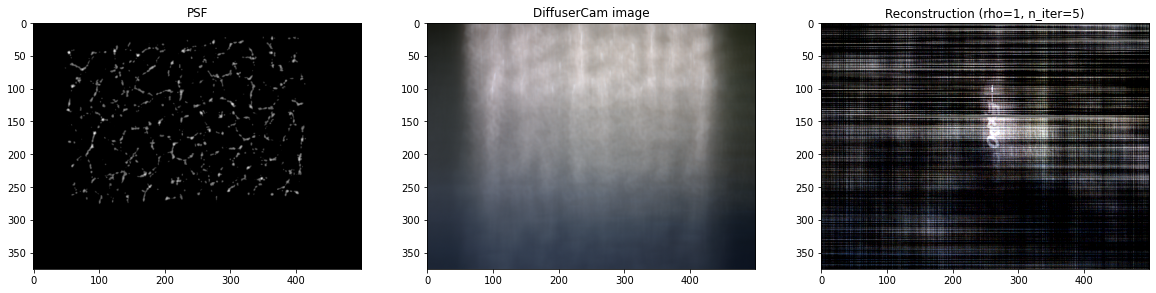

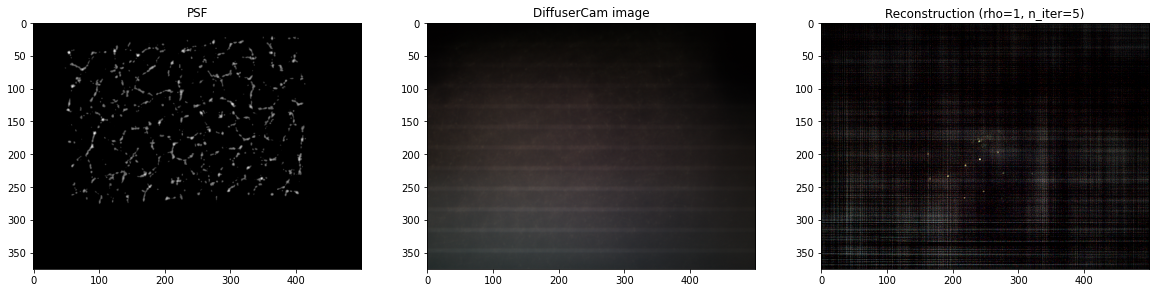

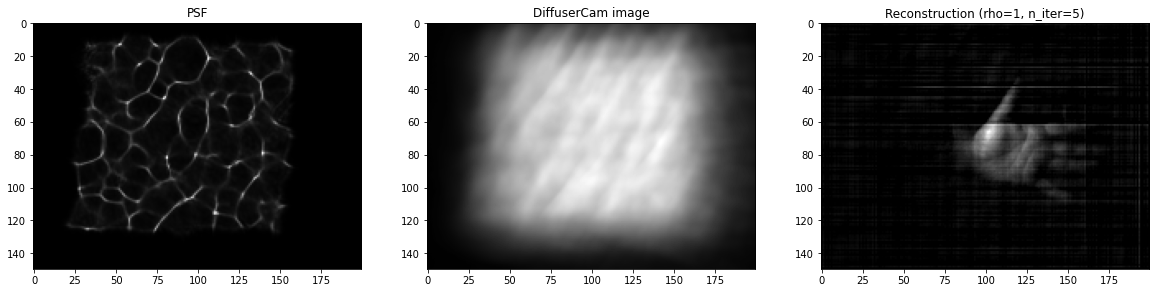

In [75]:
""" Utility function to threshold the background in the PSF image. This is helpful because the PSF measurements in our lab setup are noisy.
" psf is the PSF image to filter
"""
def filter_psf(psf):
    psf[psf < (0.3 * 255)] = 0
    return psf

""" Reconstructs the scene.
" psf is the filename of the PSF iamge
" imgs is an array of DiffuserCam images
" downsample_factor is the amount to downsample the PSF and DiffuserCam images
" filter determines whether to filter the input PSF image
" show_plots determines whether image plots will be displayed
"""
def reconstruct(psf, imgs, downsample_factor=(1.0/8.0), rho=1, num_iter=5, filter=True, show_plots=False, rgb=True):
    # Read in the PSF image.
    psf = cv2.imread(psf, cv2.IMREAD_GRAYSCALE).astype(float)
    if filter:
        psf = filter_psf(psf)
    psf = resize(psf, downsample_factor) / 255

    outputs = []
    # Iterate through the images and reconstruct them one at a time.
    for img in imgs:
        img = cv2.imread(img).astype(float) if rgb else cv2.imread(img, cv2.IMREAD_GRAYSCALE).astype(float)
        img = resize(img, downsample_factor) / 255
        if rgb:
            r = pnp_admm(img[:,:,0], psf, rho, num_iter)
            g = pnp_admm(img[:,:,1], psf, rho, num_iter)
            b = pnp_admm(img[:,:,2], psf, rho, num_iter)
            reconstruction = np.dstack((r, g, b))
        else:
            reconstruction = pnp_admm(img, psf, rho, num_iter)
        reconstruction *= 255
        outputs.append(reconstruction)
        if show_plots:
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 3, 1)
            plt.title('PSF')
            plt.imshow(psf, cmap='gray')
            plt.subplot(1, 3, 2)
            plt.title('DiffuserCam image')
            plt.imshow(img, cmap='gray') if not rgb else plt.imshow(img)
            plt.subplot(1, 3, 3)
            plt.title(f'Reconstruction (rho={rho}, n_iter={num_iter})')
            plt.imshow(reconstruction, cmap='gray') if not rgb else plt.imshow(reconstruction)
        # plt.show()
    return outputs

reconstruct('img/batch2/psf.tiff', ['img/batch2/marker.tiff', 'img/batch2/grapes.tiff'], show_plots=True)
# reconstruct('img/batch2/psf.tiff', ['img/batch2/marker.tiff'], filter=False, show_plots=True)
reconstruct('img/psf.tif', ['img/measurement.tif'], filter=False, show_plots=True, rgb=False)
# reconstruct('img/batch1/psf.tiff', ['img/batch1/thor_box.tiff'], filter=True, show_plots=True)
# reconstruct('img/batch2/psf.tiff', ['img/batch2/thor.tiff'], filter=True, show_plots=True)